In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from tqdm import tqdm
import acd
from copy import deepcopy
import torchvision.utils as vutils
from torch.optim import lr_scheduler
from sklearn.metrics import r2_score
import time
import models
from visualize import *
from data import *
sys.path.append('../trim')
from transforms_torch import transform_bandpass, tensor_t_augment, batch_fftshift2d, batch_ifftshift2d
from trim import *
from util import *
from attributions import *
from captum.attr import *
from functools import partial
import itertools
import warnings
warnings.filterwarnings("ignore")
data_path = './cosmo'
from torchsample import transforms
import tensorflow_datasets as tfds
from outlier.datasets import gaussian_convergence

## Load data

tf.Tensor([0.16992588 0.7251126 ], shape=(2,), dtype=float32)


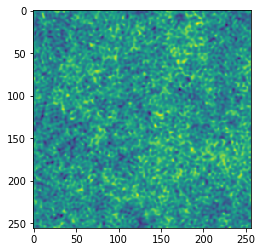

In [2]:
# load dataset
dataset, info = tfds.load(name="gaussian_convergence", split="train", with_info=True)

# viz
for example in dataset.take(1):  # Only take a single example
    kappa_map, params = example["map"], example["params"]
    plt.imshow(kappa_map)
    print(params)

In [3]:
# convert to torch
Kappa_map = []
Params = []
for example in dataset:  # Only take a single example
    kappa_map, params = example["map"].numpy(), example["params"].numpy()
    Kappa_map.append(kappa_map)
    Params.append(params)
Kappa_map = np.array(Kappa_map)
Params = np.array(Params)

Convert to torch

In [4]:
# dataset
n_ims = 20000

train_size = int(0.8 * n_ims)
test_size = int(0.2 * n_ims)

# transforms
rotation = transforms.RandomRotate(30)
flip_h = transforms.RandomFlip(h=True, v=False, p=0.5)
flip_v = transforms.RandomFlip(h=False, v=True, p=0.5)
transformer = transforms.Compose([flip_h, flip_v])

mnu_dataset_train = MyDataset(Kappa_map[:train_size],  
                              Params[:train_size],
                              transform=transformer)
mnu_dataset_test = MyDataset(Kappa_map[train_size:],  
                             Params[train_size:],
                             transform=transformer)

# dataloader
data_loader_train = torch.utils.data.DataLoader(mnu_dataset_train, batch_size=32, shuffle=True, num_workers=4)
data_loader_test = torch.utils.data.DataLoader(mnu_dataset_test, batch_size=32, shuffle=False, num_workers=2)

# load model
model = models.load_model(model_name='resnet18', device=device, num_params=2, inplace=False, data_path=None).to(device)

## Train model

In [5]:
def train_model(model, dataloader_train, dataloader_test, criterion, optimizer, 
                scheduler, num_epochs=20, out_dir = '/home/ubuntu/transformation-interpretability/ex_cosmology/models'):
    since = time.time()

    best_model_wts = deepcopy(model.state_dict())
    best_loss = 1e10
    train_losses = []
    test_losses = []
    learning_rates= []
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = dataloader_train
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = dataloader_test

            running_loss = 0.0
            
            # Iterate over data.
            for data in dataloader:
                inputs, params = data
                inputs = inputs.to(device)
                params = params.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, params)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                if phase == 'train':
                    train_losses.append(loss.item())
                else:
                    test_losses.append(loss.item())
            if phase == 'train':
                scheduler.step()
                learning_rates.append(scheduler.get_lr())
            
            if phase == 'train':
                epoch_loss = running_loss / len(mnu_dataset_train)
            else:
                epoch_loss = running_loss / len(mnu_dataset_test)
            
            print('{} Loss: {:.4f} '.format(
                phase, epoch_loss))
            
            if phase == 'test' and epoch_loss < best_loss:
                torch.save(deepcopy(model.state_dict()), opj(out_dir, f'resnet18_full_state_dict_{epoch}.pkl'))
                best_loss = epoch_loss
                best_model_wts = deepcopy(model.state_dict())                

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_losses, test_losses, learning_rates

In [6]:
criterion = torch.nn.MSELoss()

# Observe that all parameters are being optimized
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

In [7]:
model_ft, train_loss_trace, test_loss_trace, lr_trace = train_model(model, data_loader_train, data_loader_test,
                                                                    criterion, optimizer, exp_lr_scheduler, num_epochs=30)

Epoch 0/29
----------
train Loss: 0.0262 
test Loss: 0.0168 
Epoch 1/29
----------
train Loss: 0.0155 
test Loss: 0.0148 
Epoch 2/29
----------
train Loss: 0.0150 
test Loss: 0.0141 
Epoch 3/29
----------
train Loss: 0.0131 
test Loss: 0.0143 
Epoch 4/29
----------
train Loss: 0.0127 
test Loss: 0.0162 
Epoch 5/29
----------
train Loss: 0.0128 
test Loss: 0.0152 
Epoch 6/29
----------
train Loss: 0.0109 
test Loss: 0.0153 
Epoch 7/29
----------
train Loss: 0.0097 
test Loss: 0.0161 
Epoch 8/29
----------
train Loss: 0.0092 
test Loss: 0.0173 
Epoch 9/29
----------
train Loss: 0.0074 
test Loss: 0.0165 
Epoch 10/29
----------
train Loss: 0.0061 
test Loss: 0.0165 
Epoch 11/29
----------
train Loss: 0.0054 
test Loss: 0.0169 
Epoch 12/29
----------
train Loss: 0.0043 
test Loss: 0.0167 
Epoch 13/29
----------
train Loss: 0.0035 
test Loss: 0.0165 
Epoch 14/29
----------
train Loss: 0.0031 
test Loss: 0.0164 
Epoch 15/29
----------
train Loss: 0.0024 
test Loss: 0.0162 
Epoch 16/29
------

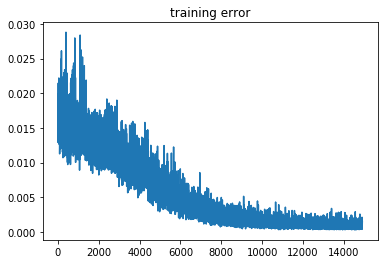

In [8]:
# analyze model
plt.plot(train_loss_trace[100:])
plt.title("training error")
plt.show()

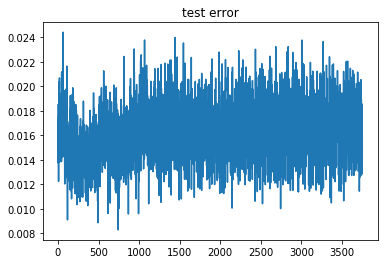

In [9]:
# analyze model
plt.plot(test_loss_trace)
plt.title("test error")
plt.show()

In [10]:
# train predict
model.eval()
train_preds = torch.Tensor()
train_params = torch.Tensor()
with torch.no_grad():
    for data in data_loader_train:
        inputs, params = data
        inputs = inputs.to(device)
        params = params.to(device)
        outputs = model(inputs)
        train_preds = torch.cat((train_preds, outputs.cpu()), 0)
        train_params = torch.cat((train_params, params.cpu()), 0)
        
# test predict
model.eval()
test_preds = torch.Tensor()
test_params = torch.Tensor()
with torch.no_grad():
    for data in data_loader_test:
        inputs, params = data
        inputs = inputs.to(device)
        params = params.to(device)
        outputs = model(inputs)
        test_preds = torch.cat((test_preds, outputs.cpu()), 0)
        test_params = torch.cat((test_params, params.cpu()), 0)

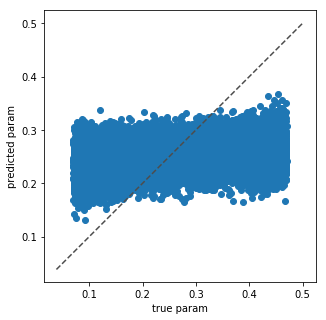

In [11]:
f, ax = plt.subplots(figsize=(5, 5))
ax.scatter(train_params[:,0], train_preds[:,0])
ax.set_xlabel('true param')
ax.set_ylabel('predicted param')
ax.set_aspect('equal')
ax.plot(ax.get_xlim(), ax.get_xlim(), ls="--", c=".3")
plt.show()

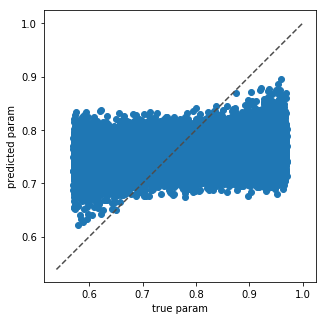

In [12]:
f, ax = plt.subplots(figsize=(5, 5))
ax.scatter(train_params[:,1], train_preds[:,1])
ax.set_xlabel('true param')
ax.set_ylabel('predicted param')
ax.set_aspect('equal')
ax.plot(ax.get_xlim(), ax.get_xlim(), ls="--", c=".3")
plt.show()

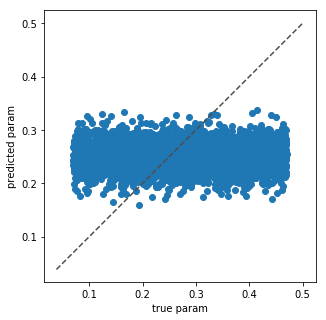

In [13]:
f, ax = plt.subplots(figsize=(5, 5))
ax.scatter(test_params[:,0], test_preds[:,0])
ax.set_xlabel('true param')
ax.set_ylabel('predicted param')
ax.set_aspect('equal')
ax.plot(ax.get_xlim(), ax.get_xlim(), ls="--", c=".3")
plt.show()

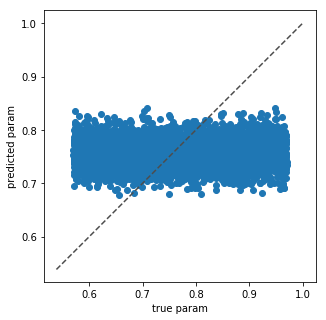

In [14]:
f, ax = plt.subplots(figsize=(5, 5))
ax.scatter(test_params[:,1], test_preds[:,1])
ax.set_xlabel('true param')
ax.set_ylabel('predicted param')
ax.set_aspect('equal')
ax.plot(ax.get_xlim(), ax.get_xlim(), ls="--", c=".3")
plt.show()

In [15]:
coefficient_of_dermination = r2_score(params.cpu()[:,1], outputs.cpu()[:,1])

In [16]:
coefficient_of_dermination

-0.08499064504705967